<a href="https://colab.research.google.com/github/acoiman/wildfire_modeling/blob/main/yosemite_wildfire_modeling_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wildfire Modeling in Yosemite National Park

Wildfire modeling uses computational science to perform numerical simulations of fire events in order to understand and predict fire behavior. Wildfire modeling has many applications that encompass firefighter security, damage reduction, and protection of ecosystem services (Wikipedia. 2021).

In this tutorial, we will show you how to model wildfire events using the [r.ros](https://grass.osgeo.org/grass82/manuals/r.ros.html) and [r.spread](https://grass.osgeo.org/grass83/manuals/r.spread.html) modules of  [GRASS GIS](https://grass.osgeo.org/). We will perform fire simulations in three areas in the [Yosemite National Park](https://www.nps.gov/yose/index.htm) located in California USA (<a href='#Figure 1'>Figure 1</a>) during the summer season in 2020 (`from 2020-06-20 through 2020-09-22`). This tutorial has three main sections:<a href='#Getting Data'>Getting Data</a>, <a href='#Importing Data'>Importing Data</a>, and <a href='#Wildfire Simulation'>Wildfire Simulation</a>.

To follow along this tutorial, please run this Jupyter Notebook in Colaboratory Platform by cliking the folowing button.

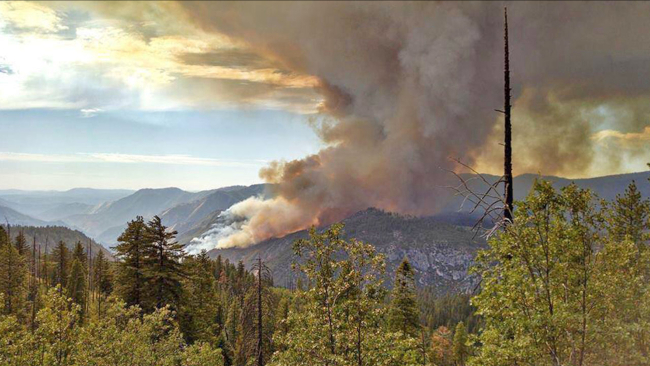

<center>Source: https://abc7.com/</center>

<a id='Getting Data'></a>
# 1. Getting Data

Getting the data we need to feed our models could be a daunting activity. Sometimes, data are not readily available because they are sparse or dispersed over a wide range of sources. In this section, we will show you an approach to readily gather data for wildfire modeling purposes. Table 1 shows the data used in this tutorial.

<center><strong>Table 1. Data used in this tutorial</strong></center>

| **Data**                              | **Source**                                                   | **Link**                                                     |
|:------------------------------------- |:------------------------------------------------------------ |:------------------------------------------------------------ |
| Yosemite National   Park polygon      | WDPA:  World Database on   Protected Areas (polygons)        | https://developers.google.com/earth-engine/datasets/catalog/WCMC_WDPA_current_polygons |
| 100-hour dead   fuel moisture         | GRIDMET: University of  Idaho Gridded Surface   Meteorological Dataset | https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET |
| Wind direction                        | GRIDMET: University of   Idaho Gridded Surface   Meteorological Dataset | https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET |
| Wind velocity                         | GRIDMET: University of   Idaho Gridded Surface   Meteorological Dataset | https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET |
| Enhanced Vegetation   Index (EVI)     | Google Earth Engine (GEE)                                    | https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_32DAY_EVI |
| Landsat 8 Surface   Reflectance       | USGS                                                         | https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR |
| High resolution   multispectral image | Planet Team (2017)                                           | https://api.planet.com                                       |
| Anderson Fire   Behavior Fuel Model   | LANDFIRE (LF) program                                        | https://landfire.cr.usgs.gov/fbfm13.php                      |


## 1.1 Loading Packages

This tutorial assumes you are working in a Python environment with all required packages. You also need to install the latest version of GRASS GIS and have an active GEE account. Our Python environment is based on a traditional Anaconda installation on Ubuntu 20.04, see details [here](https://docs.anaconda.com/anaconda/install/linux/).  You need to install the following packages that are not contained in Anaconda: **Geopandas, GEE Python API, eeconvert, geemap**. Installing these packages is beyond the scope of this tutorial, so Google them to find out how to install and configure these packages.  

Let's load all Python packages needed for this tutorial.

In [ ]:
# GDF (GeoDataFrame) manipulation
import geopandas as gpd

# GEE data
import eeconvert
import geemap
import ee

# path libraries
import os
import sys
import subprocess

# display images
from IPython.display import Image
from subprocess import PIPE
from PIL import Image as Img

# avoid warning messages
import warnings
warnings.filterwarnings('ignore')


## 1.2 Downloading Data from GEE

We will use GEE Python API to download data from GEE cloud services and save the requested data in our local disk. First of all, we will initialize GEE.

In [ ]:
# initialize GEE
ee.Initialize()

Next, we call the WDPA FeatureCollection (FC) and extract the Yosemite National Park polygon. We will convert the extracted FC into a GeoDataFrame (GDF) and save it as a shapefile into our working directory.

In [ ]:
# get World Data Protected Areas (WDPA) FeatureCollection
pa = ee.FeatureCollection("WCMC/WDPA/current/polygons")

# Yosemite National Park polygon
filter = ee.Filter.inList('NAME', ['Yosemite National Park'])
yosemite = pa.filter(filter)

# transform Yosemite fc into gdf
yosGDF = eeconvert.fcToGdf(yosemite)

# convert gdf into shp
yosGDF.to_file("gisdata/yosemite/shp/yosemite.shp")

The following line of code allows us to set up an interactive map with Google Earth Engine (GEE) using [geemap](https://geemap.org/) package. We calculate the centroid of the protected area boundaries and get its coordinates. We then pass these coordinates to a geemap object, add the Yosemite layer and configure map controls.

In [ ]:
# get centroid coordinates of Yosemite polygon
yosemite_center = yosemite.geometry().centroid().getInfo()['coordinates']
yosemite_center.reverse()

# center lat and lot
lat = float(yosemite_center[0])
lon = float(yosemite_center[1])

# pass parameters
Map = geemap.Map(center=(lat, lon), zoom=9)
Map.addLayer(yosemite, {}, 'Yosemite National Park', True, 0.5)
Map.add_minimap(zoom=4, position='bottomright')

# add map controls
Map.addLayerControl()

<a id='Figure 1'></a>
<center><strong>Figure 1. Yosemite National Park</strong></center>

In [ ]:
Map

Map(center=[37.84802961309633, -119.55716609046931], controls=(WidgetControl(options=['position'], widget=HBox…

According to Northern Rockies Coordination Center(n.d.): "100-Hour Fuel Moisture (100-hr FM) represents the modeled moisture content of dead fuels in the 1 to 3 inch diameter class. It can also be used as a very rough estimate of the average moisture content of the forest floor from three-fourths inch to four inches below the surface."

To obtain 100-Hour Fuel Moisture data from GEE we need first to call the GRIDMET ImageCollection and filter by date. Second, we create a rectangle that will be used to clip the data. Next, we select 100-hour dead fuel moisture (`fm100`) and calculate the mode. We then clip the resulting Image to the previously created polygon. After that, we create 2000 random points that will be used to sample the Image using the mean. Finally, we transform the resulting FC into a GeoDataFrame and save this GDF as a shapefile into our working directory.

In [ ]:
# load GRIDMET ImageCollection
gridmet = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET') \
    .filter(ee.Filter.date('2020-06-20', '2020-09-22'));

# create a rectangle
coords = [-120.10157709250639,37.36645735913506,-118.99122199244081,38.31280791348237]
bbox = ee.Geometry.Rectangle(coords)

# select 100-hour dead fuel moisture (fm100) and calculate the mode
fm100 = gridmet.select('fm100').mode()

# clip data to rectangle
fm100_clip =fm100.clip(bbox)

# create 2000 random points
fm100_points = ee.FeatureCollection.randomPoints(bbox, 2000);

# sample points using the mean
samplefm100 = fm100_clip.reduceRegions(**{
  'collection':fm100_points,
  'reducer':ee.Reducer.mean(),
  'scale': 4000,
  });

# transform fc into gdf
samplefm100GDF = eeconvert.fcToGdf(samplefm100)

# convert gdf into shp
samplefm100GDF.to_file("gisdata/yosemite/shp/samplefm100.shp")

To obtain Wind Direction data from GEE we need first to select the GRIDMET Wind direction (`th`) band  and calculate the mode. Second, we clip the resulting Image to the previously created polygon. After that, we create 2000 random points that will be used to sample the Image using the mean. Finally, we transform the resulting FC into a GeoDataFrame and save this GDF as a shapefile into our working directory.

In [ ]:
# select wind direction and calculate the mode
th = gridmet.select('th').mode()

# clip data to rectangle
th_clip =th.clip(bbox)

# create 2000 random points
th_points = ee.FeatureCollection.randomPoints(bbox, 2000);

# sample points using the mean
sampleth = th_clip.reduceRegions(**{
  'collection':th_points,
  'reducer':ee.Reducer.mean(),
  'scale': 4000,
});

# transform fc into gdf
samplethGDF = eeconvert.fcToGdf(sampleth)

# convert gdf into shp
samplethGDF.to_file("gisdata/yosemite/shp/sampleth.shp")

To obtain Wind Velocity data from GEE we need first to select the GRIDMET Wind velocity (`vs`) band  and calculate the mode. Second, we clip the resulting Image to the previously created polygon. Next, we create 2000 random points that will be used to sample the Image using the mean. After that, we transform the resulting FC into a GeoDataFrame and create a new column where we store values in Foot per Minute. Finally, we save this GDF as a shapefile into our working directory.

In [ ]:
# select wind velocity and calculate the mode
vs = gridmet.select('vs').mode()

# clip data to rectangle
vs_clip =vs.clip(bbox)

# create 2000 random points
vs_points = ee.FeatureCollection.randomPoints(bbox, 2000);

# sample points using the mean
samplevs = vs_clip.reduceRegions(**{
  'collection':vs_points,
  'reducer':ee.Reducer.mean(),
  'scale': 4000,
});

# transform fc into gdf
samplevsGDF = eeconvert.fcToGdf(samplevs)

# transform values from meter per second to foot per minute
samplevsGDF['vsfpm'] = samplevsGDF['mean']*197

# convert gdf into shp
samplevsGDF.to_file("gisdata/yosemite/shp/samplevs.shp")

To get EVI data from GEE we need first to call the Landsat 8 Collection 1 Tier 1 32-Day EVI Composite, filter by date and bounds using Yosemite FC. Then, we calculate a mean Image and clip it using the previously created polygon. Finally, we export the clipped Image to our Google Drive storage and from there we download it to our working directory.

In [ ]:
# load Landsat 8 Collection 1 Tier 1 32-Day EVI Composite
evi = ee.ImageCollection('LANDSAT/LC08/C01/T1_32DAY_EVI') \
            .filterDate('2020-06-20', '2020-09-22') \
            .filterBounds(yosemite)

# get mean image
evi_mean = evi.select('EVI').mean()

# clip data to rectangle
evi_clip = evi_mean.clip(bbox)

# export image to google drive
geemap.ee_export_image_to_drive(evi_clip, description='evi', folder='export', region=bbox, scale=30)

In this tutorial, we use Landsat 8 images only for visualization purposes. To get Landsat 8 data from GEE we need first to call the USGS Landsat 8 Surface Reflectance Tier 1 collection, filter by date, cloudiness, and bounds using the Yosemite FC. Then, we calculate a median Image and clip it using the previously created polygon. Finally, we export the clipped Image to our Google Drive storage and from there we download it to our working directory.

In [ ]:
# load landsat 8 sr image collection
l8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")

# filter image collection by bounds, date and cloud cover
l8_filter = l8.filterDate('2016-06-20', '2016-09-22') \
            .filterMetadata("CLOUD_COVER", "less_than", 10)
            .filterBounds(yosemite)

# get median image
image = l8_filter.median()

# clip data to rectangle
image = image.clip(bbox)

# export image to google drive
geemap.ee_export_image_to_drive(image, description='landsat', folder='export', region=bbox, scale=30)

## 1.2 Downloading  Fire Behavior Fuel Model

To run our fire simulation we need a fuel model defined by the USDA Forest Service. In this case, we use the 13 Anderson Fire Behavior Fuel Model available at https://landfire.cr.usgs.gov/fbfm13.php . This model has 13 classes of fuel which vary in load, distribution, and particle size (Petrasova, et.al., 2018) (Table 2).

<center><strong>Table 2. Anderson Fuel Model Classes</strong></center>

| Fuel class            | Description                    |
| :-------------------  | :----------------------------- |
| Grass and grass-dominated                              |
| 1                     | Short grass (1 foot)           |
| 2                     | Timber (grass and understory)  |
| 3                     | Tall grass (2.5 feet)          |
| Chaparral and shrub fields                             |
| 4                     | Chaparral (6 feet)             |
| 5                     | Brush (2 feet)                 |
| 6                     | Dormant brush, hardwood slash  |
| 7                     | Southern rough                 |
| Timber litter                                          |
| 8                     | Closed timber litter           |
| 9                     | Hardwood litter                |
| 10                    | Timber (litter and understory) |
| Slash                                                  |                                                                 
| 11                    | Light logging slash            |
| 12                    | Medium logging slash           |
| 13                    | Heavy logging slash            |


To download our Fire Behavior Fuel Model we need to go to the LANDFIRE Data Distribution Site (DDS) select LF Remap tab and click on any US states (Figure 2)


<center><strong>Figure 2. LANDFIRE Data Distribution Site (DDS)</strong></center>
<img src="gisdata/yosemite/images/dds_1.png" width="400" align="center">

We will be redirected to the map viewer where we should click on the download icon located on the map toolbar. In the map layer content, we should expand `Fuel Capable 2020` and `Surface and Canopy`. Next, we should select the layer named `us_200 13 Fire Behavior Fuel Models-Anderson (2020)` and click on the third icon at `Click one of the buttons above to start` (Figure 3).
<br>
<br>
<center><strong>Figure 3. LANDFIRE  Map Viewer</strong></center>
<img src="gisdata/yosemite/images/dds_4.png" width="1100" align="center">

In the form that appears enter the coordinates shown in the cell below and click on `Download Area`(Figure 4). Follow the instructions to download the data to your working directory.

<center><strong>Figure 4. LANDFIRE Download Form</strong></center>
<img src="gisdata/yosemite/images/dds_5.png" width="300" align="center">

In [ ]:
# use yosemite GDF bounds to get coordinates for downloading data from LANDFIRE Map Viewer
minx, miny, maxx, maxy = yosGDF.geometry.total_bounds
(minx, miny, maxx, maxy)

(-119.8863742093013, 37.4938205831069, -119.19951217057367, 38.18634574204428)

<a id='Importing Data'></a>

# 2. Importing Data

Now, we will proceed to import the data we download from GEE and other sources. This section involves setting up our GRASS GIS environment and loading the data itself.


## 2.1 Setting up GRASS GIS

When setting up GRASS in Jupyter Notebook we use Python to initialize GRASS GIS. First, we create a GRASS GIS runtime environment by passing in a variable the directory where GRASS GIS "lives" and tie it to the Python directory. Next, we import GRASS GIS packages. After that, we set up default font displays and the overwrite behavior so that we do not need to add the `--overwrite` flag every time we execute a command.

**It is important to highlight that every time you start again the notebook you only need to run subsection `1.1 Loading Packages` and this one because we are mainly working with commands.**

In [ ]:
# create GRASS GIS runtime environment
gisbase = subprocess.check_output(["grass", "--config", "path"], text=True).strip() # directory where GRASS GIS lives
os.environ['GISBASE'] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

In [ ]:
# import grass gis package
import grass.script as gs
import grass.script.setup as gsetup
from grass.pygrass.modules import Module
from grass import script
from grass.pygrass.modules.shortcuts import raster as r, vector as v, general as g, display as d
from grass.pygrass.modules import Module as run_command
import grass.imaging as imaging

In [ ]:
# default font displays
os.environ['GRASS_FONT'] = 'sans'
# overwrite existing maps
os.environ['GRASS_OVERWRITE'] = '1'
gs.set_raise_on_error(True)
gs.set_capture_stderr(True);

You previously need to create a Location in GRASS GIS using the GUI to run the following cell. In our case, we created a Location named yosemite_3310_2 and a Mapset called wf_mod_2. You can name your Location and Mapset as you wish. **The second time you run the notebook you should comment lines 2 and 5.***

In [ ]:
# set GRASS GIS session data
# cfile = gsetup.init(gisbase, "grassdata", "yosemite_3310_2", "PERMANENT")

# create a new maset inside yosemite_3310_2 location
# g.mapset(flags='c', mapset='wf_mod_2', location='yosemite_3310_2');

# set GRASS GIS session data
cfile = gsetup.init(gisbase, "grassdata", "yosemite_3310_2", "wf_mod_2");

## 2.2 Loading Data

In this subsection, we will upload all the datasets we need to run our fire simulation.  Let's import our fuel model raster.

In [ ]:
# import fuel model raster
# your path could differ, so set you path accordingly
script.run_command('r.import', input='gisdata/yosemite/raster/ffm/us_200f13_20/hdr.adf',output='fuel', \
    resolution='value', resolution_value=30.0);

Next, we set the Region to `fuel` raster and print its information.

In [ ]:
# set region
g.region(raster='fuel')

# print region info
print(g.region(flags='p', stdout_=PIPE).outputs.stdout)

projection: 99 (NAD83 / California Albers)
zone:       0
datum:      nad83
ellipsoid:  grs80
north:      33210
south:      -72240
west:       -8880
east:       88980
nsres:      30
ewres:      30
rows:       3515
cols:       3262
cells:      11465930



Once we set the region, we will proceed to import other required datasets.

In [ ]:
# import Yosemite National Park vector
script.run_command('v.import', input='gisdata/yosemite/shp/yosemite.shp',output='yosemite')

# import evi raster
script.run_command('r.import', input='gisdata/yosemite/raster/evi.tif', output='evi', \
    resolution='value', resolution_value=30.0)

# import fm 100h samples
script.run_command('v.import', input='gisdata/yosemite/shp/samplefm100.shp', \
                   output='samplefm100')

# import vs (wind velocity) samples
script.run_command('v.import', input='gisdata/yosemite/shp/samplevs.shp', \
                   output='samplevs')

# import th (wind direction) samples
script.run_command('v.import', input='gisdata/yosemite/shp/sampleth.shp', \
                   output='sampleth')

# import landsat image
script.run_command('r.import', input='gisdata/yosemite/raster/landsat/landsat.tif',output='landsat', \
                   resolution='value', resolution_value=30.0);

The following datasets will be used to define our study area. They are stored in our repository, so you only need to import them if you cloned the repository.

In [ ]:
# import South Fork fire perimeter
# this data was obtained from https://gis-california.opendata.arcgis.com/
script.run_command('v.import', input='gisdata/yosemite/shp/south_fork.shp', \
                   output='south_fork')

# import study area 2 shapefile
script.run_command('v.import', input='gisdata/yosemite/shp/sa_2.shp', \
                   output='sa_2')

# import study area 3 shapefile
script.run_command('v.import', input='gisdata/yosemite/shp/sa_3_3.shp', \
                   output='sa_3');

Finally, we will create a Digital Elevation Model (DEM) from 1 arcsec NASADEM tiles. We import a DEM 30m spatial resolution from NASA DEM using the `r.in.nasadem` module. You need to register at https://urs.earthdata.nasa.gov/users/new in order to get a user and password that will be used as parameters for this module.

<p style="color:#FF0000"><strong>This module should be executed in the shell because it does not work in Jupyter Notebook.</strong></p>

In [ ]:
# execute in shell not working in jupyter notebook
%%bash
r.in.nasadem user="my_nasa_user" password="my_nasa_pw" output=dem memory=2000 resolution=30

<a id='Wildfire Simulation'></a>

# 3. Wildfire Simulation

We will simulate wildfire spread in three areas in the Yosemite National Park (<a href='#Figure 5'>Figure 5</a>). For each area, we will derive new data from the imported data, model fire events with different durations, and visualize wildfire propagation.

## 3.1 Creating a Map of the Study Areas
We will begin fire simulation by creating a map showing our study areas using GRASS GIS tools. We set the Region to the rectangular extent of the Yosemite National Park and use its boundaries as a mask.

In [ ]:
# set region to yosemite
g.region(vector='yosemite')
# set mask
r.mask(vector='yosemite');

The following code snippet allows us to generate a vector showing the extent of each study area. To accomplish this goal, we set the Region to each imported vector. Next, we name and save each Region. Lastly, we create vector polygons from each Region extent.  

In [ ]:
# calculate study area 1 from vector bbox
# set region to south_fork
g.region(vector='south_fork')
g.region(grow=50, save='sa_1R') # we grow the region to better visualize map elements
# creates a vector polygon from the region extent
script.run_command('v.in.region',output='sa_1R_Vect')

# calculate study area 2 from vector bbox
# set region to study area 2
g.region(vector='sa_2')
g.region(save='sa_2R')
# creates a vector polygon from the region extent
script.run_command('v.in.region',output='sa_2R_Vect');

# calculate study area 3 from vector bbox
# set region to to study area 3
g.region(vector='sa_3')
g.region(save='sa_3R')
# creates a vector polygon from the region extent
script.run_command('v.in.region',output='sa_3R_Vect');

As we are interested in showing the extent of the Yosemite National Park, we'll set again the Region to the park's boundaries and grow the Region to better visualize map elements.

In [ ]:
# set region to yosemite
g.region(vector='yosemite')
g.region(grow=200);

Now, we will create an image composite that will serve as a basemap. To begin creating this basemap we'll create a shaded relief map from our DEM. Next, we generate RGB raster map layers combining HIS values. Finally, we'll combine red, green, and blue raster maps into a single composite raster map.

In [ ]:
# create a shaded relief map
r.relief(input='dem', output='dem_shaded');

# generate RGB raster
r.his(hue='dem', intensity='dem_shaded', red='dem.r', green='dem.g', blue='dem.b')

# combine red, green and blue raster maps
r.composite(red='dem.r', green='dem.g', blue='dem.b', output='dem.his');

In the cell below, we set display modules to render into a file named map.png. You only need to execute this cell to render this map.

<p style="color:#FF0000"><strong>To render other maps you must shut down the kernel and open again the notebook.</strong></p>

In [ ]:
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'

After setting up our display modules, we can render our map of study areas. In the cell below we use various GRASS GIS display commands to render our study areas, Yosemite polygon, basemap, and some map components.

In [ ]:
# erase the display before drawing again
script.run_command('d.erase')
# remove the legend file
!rm -f $GRASS_LEGEND_FILE
# display dem composite
script.run_command('d.rast', map="dem.his")
# display Yosemite polygon
script.run_command('d.vect', map="yosemite", width=2, fill_color='none', \
                   legend_label="Yosemite NP boundaries")
# display study area 1 region vector
script.run_command('d.vect', map="sa_1R_Vect", width=2, fill_color='none', \
                   legend_label="Study Area 1", color='green')
# display study area 2 region vector
script.run_command('d.vect', map="sa_2R_Vect", width=2, fill_color='none', \
                   legend_label="Study Area 2", color='blue')
# display study area 3 region vector
script.run_command('d.vect', map="sa_3R_Vect", width=2, fill_color='none', \
                   legend_label="Study Area 3", color='red')
# display north arrow
script.run_command('d.northarrow', style='9',at=(8,85))
# display map title
script.run_command('d.text', text='Study Areas', color='red', size=5)
# display vector legend
script.run_command('d.legend.vect', at=(2,25), symbol_size=20)
# display bar scale
script.run_command('d.barscale', segment=10, length=30, units='kilometers', at=(40,5.0));

<a id='Figure 5'></a>
<center><strong>Figure 5. Study Areas</strong></center>

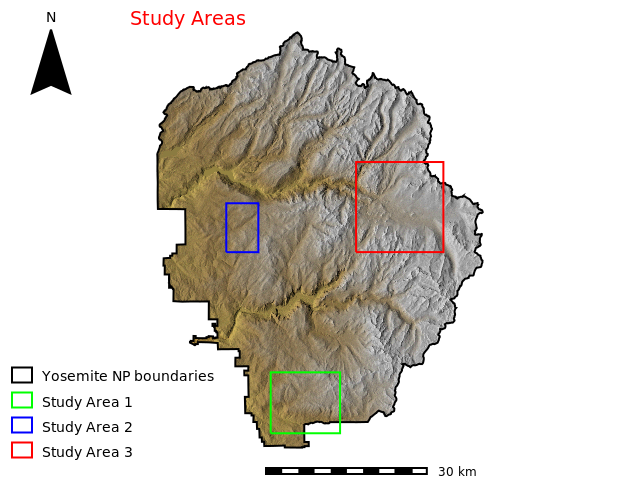

In [ ]:
# render the map
Image(filename="map.png")

## 3.2 Study Area 1

Study area 1 is located in the south of the Yosemite National Park  (<a href='#Figure 5'>Figure 5</a>). Mean slope is 13.95 degree, mean wind speed is 545.45 foot/min, and mean dead fuel moisture 1 hour is 2.79%. Predominant fuel classes are Timber (litter and understory) with a coverage of 23% and Timber (grass and understory) covering 20% of the study area (to learn more about fuel classes click [here](https://iftdss.firenet.gov/firenetHelp/help/pageHelp/content/10-mapstudio/files/fbfmsummaries.htm)). According to the NLCD: USGS National Land Cover Database (Yang et.al.,2018), this area is mainly covered by evergreen forest (80%) and  shrub/scrub (16%) (Figure 6).

<center><strong>Figure 6. Vegetation in Study Area 1</strong></center>
<img src="gisdata/yosemite/images/sa_1.jpg" width="400" align="center">
<center>Source: Google Maps Photos</center>

The goal of the fire simulation in this area is to ascertain if our simulated fire has the same spread as a past fire event called ['South Fork'](https://www.nps.gov/yose/blogs/south-fork-fire-august-14-2017.htm) that occurred in 2017.

We'll begin by setting our Region to Study Area 1.

In [ ]:
# set region
g.region(region='sa_1R');

### 3.2.1 Calculating Data

Modeling wildfire events is a two-step process. First, we execute the `r.ros` module that generates Rate of Spread (ROS) raster maps. Second, we run the `r.spread` module that simulates elliptically anisotropic spread.

As we assume windy and topographically sharp conditions, r.ros module needs the following map inputs:

- model: raster map containing fuel model.
- moisture_1h: raster map containing the 1-hour fuel moisture (%).
- moisture_live: raster map containing live fuel moisture (%).
- velocity: raster map containing wind velocities (ft/min).
- direction: raster map containing wind directions (degree).
- slope: raster map containing slope (degree).
- aspect: raster map containing aspect, counterclockwise from east (GRASS convention) in degrees.
- elevation: raster map containing elevation (m).

We'll use the `v.surf.idw` module to derive the `moisture_100h` raster map from vector point (`samplefm100`)  by Inverse Distance Squared Weighting. To calculate `moisture_1h` raster we'll use the following expression:


$$moisture{\_}100h = moisture{\_}10h + 1 = moisture{\_}1h + 2 \ (GRASS \ Development \ Team,\ 2021)$$


`r.mapcal` module will be run to calculate `moisture_10h` from `moisture_100h` and `moisture_1h` from `moisture_10h`.

We enter the follwing expression in the `r.mapcal` module to calculate `moisture_live`:

$$LFM = (417.602 × EVI) + 6.7806\ (Myoung, et.al.,2018)$$

Where `LFM` is Live Fuel Moisture and `EVI` is Enhanced Vegetation Index. The resulting raster will be rescaled to 0-100 as we need percentage content multiplied by 100.

We'll the use v.surf.idw module to derive the `velocity` raster map from vector point (samplevs) by Inverse Distance Squared Weighting.

We'll the use v.surf.idw module to derive the `direction` raster map from vector point (sampleth) by Inverse Distance Squared Weighting.

`slope` and `aspect` raster maps will be calculated through the `r.slope.aspect` module.

As these raster maps will be calculated for each Study Area, we will write a function to carry out these tasks.

In [ ]:
def caldata(regname, suffix):

    '''Function to calculate GRASS GIS raster for slope, aspect, fuel moisture 100h, fuel moisture 10h,
    fuel moisture 1h, wind velocity, wind direction, and live fuel moisture

    :param:str regname:region name
    :param:str suffix:GRASS raster filename suffix

    :return str: successfulness message
    '''
    try:
        # set region
        g.region(region=regname)

        # calculate slope and aspect
        script.run_command('r.slope.aspect', elevation='dem', slope='slope'+suffix, aspect='aspect'+suffix)

        # calculate fuel moisture 100h raster from point data
        script.run_command('v.surf.idw', input='samplefm100', output='moisture_100h'+suffix, \
                       column='mean')

        # calculate wind velocity raster from point data
        script.run_command('v.surf.idw', input='samplevs', output='wind_speed'+suffix, \
                       column='vsfpm')

        # calculate wind direction raster from point data
        script.run_command('v.surf.idw', input='sampleth', output='wind_dir'+suffix, \
                           column='mean')

        # define variable for string concatanation
        ss1 = 'moisture_1h'
        ss10 = 'moisture_10h'
        ss100 = 'moisture_100h'
        lfm='lfm'

        # moisture_100h = moisture_10h + 1 = moisture_1h + 2
        # moisture_10h = moisture_100h -1
        expm10 = ss10+suffix+'='+ss100+suffix+'-1'
        r.mapcalc(expression=expm10)

        # moisture_100h = moisture_10h + 1 = moisture_1h + 2
        # moisture_1h =  moisture_10h -2
        expm1 = ss1+suffix+'='+ss10+suffix+'-2'
        r.mapcalc(expression=expm1)

        # estimating live fuel moisture from evi
        explfm = lfm+suffix+'=(417.602 * evi) + 6.78061'
        r.mapcalc(expression=explfm)

        # rescale LFM to 0-100
        output = lfm+suffix+'_scaled'
        r.rescale(input='lfm'+suffix, output=output, to=(0,100));

        return "successfully calculated"

    except:
        print("Something went wrong")

In [ ]:
caldata('sa_1R', '_sa_1')

'successfully calculated'

### 3.2.2  Modeling

As we mentioned, modeling wildfires is a two-step process, we execute the `r.ros` module and then the `r.spread` module. According to GRASS Development Team (2021) `r.ros` "generates three, or four raster map layers showing the base (perpendicular) rate of spread (ROS), the maximum (forward) ROS, the direction of the maximum ROS, and optionally the maximum potential [spotting distance](https://www.nwcg.gov/publications/pms437/crown-fire/spotting-fire-behavior#TOC-Estimating-Maximum-Spotting-Distance) for fire spread simulation".



The following `r.ros` outputs are the inputs of the `r.spread` module:

- base_ros: raster map containing base ROS (cm/min).
- max_ros: raster map containing maximal ROS (cm/min).
- direction_ros: raster map containing directions of maximal ROS (degree).
- spotting_distance: raster map containing maximal spotting distance (m).

Let's enter our data and run the `r.ros` module.

In [ ]:
# generate rate of spread raster map
r.ros(model='fuel', moisture_1h='moisture_1h_sa_1', \
    moisture_live='lfm_sa_1_scaled', velocity='wind_speed_sa_1', \
    direction='wind_dir_sa_1', slope='slope_sa_1', aspect='aspect_sa_1', \
    elevation='dem', base_ros='out_base_ros', \
    max_ros='out_max_ros', direction_ros='out_dir_ros', \
    spotting_distance='out_spotting');

Now, let's create a vector map from ASCII points  with the following coordinates: `37068.373955617775,-45819.944138889085`.

Once the vector map has been created, we'll rasterize it. This raster map will be the source of our fire simulation.

In [ ]:
# create a vector map from ASCII points
script.run_command('v.in.ascii',input='gisdata/yosemite/csv/source_1.txt', \
                   output='source_1', separator='comma')

# rasterize vector map
script.run_command('v.to.rast', input='source_1', output='source_1', type='point', use='cat');

As soon as we define our source, we can execute the `r.spread` module. According to GRASS Development Team (2021) `r.spread` "generates a raster map of the cumulative time of spread, given raster maps containing the rates of spread (ROS), the ROS directions, and the spread origins". It is important to note that spread phenomena show variable behavior over the space due to dissimilar conditions from place to place (spatial heterogeneity), and variable conditions in different directions (anisotropy). The simplest shaoe of a uneven spatial and anisotropic spread is an elliptical spread where each spread can be regarded as an ellipse (GRASS Development Team, 2021).

Let' run the `r.spread` module. Our start is the above-rasterized point. Our simulation period is 240 min (4 hours) because the initial time for the current simulation is `0` (default value) and our lag is `240` min. Note that we use the `"s"` flag because we are considering spotting distance.

In [ ]:
# elliptically anisotropic spread simulation 4 hours source 1
r.spread(flags="s", base_ros='out_dir_ros', max_ros='out_max_ros', \
    direction_ros='out_dir_ros', start='source_1', \
    spotting_distance='out_spotting', wind_speed='wind_speed_sa_1', \
    fuel_moisture='moisture_1h_sa_1', output='spread_4h_s1', lag=240);

For visualization purposes, we set null values to `0` and create a color table with the following rules:

$$0{\%}\ 50:50:50$$
$$60{\%}\ yellow$$
$$100{\%}\ red$$

In [ ]:
# set null values
r.null(map='spread_4h_s1', setnull=0)
# create color table
r.colors(map='spread_4h_s1', rules='gisdata/yosemite/csv/fire_colors.txt');

Let's run again the `r.spread` module. Our simulation period is `480` min (8 hours) because the initial time for the current simulation is `240` min and our lag is `240` min. Note that we use the `"si"` flags because we are considering spotting distance and our start is the output of the previous execution.

In [ ]:
# elliptically anisotropic spread simulation 8 hours source 1
script.run_command('r.spread', flags='si', base_ros='out_dir_ros', max_ros='out_max_ros', \
                   direction_ros='out_dir_ros', start='spread_4h_s1', \
                   spotting_distance='out_spotting', wind_speed='wind_speed_sa_1', \
                   fuel_moisture='moisture_1h_sa_1', output='spread_8h_s1', lag=240, init_time=240);

In [ ]:
# set null values
r.null(map='spread_8h_s1', setnull=0)
# create color table
r.colors(map='spread_8h_s1', rules='gisdata/yosemite/csv/fire_colors.txt');

Let's run again the `r.spread` module. Our simulation period is `720` min (12 hours) because the initial time for the current simulation is `480` min  and our lag is `240` min. Note that we use the "si" flags because we are considering spotting distance and our start is the output of the previous execution.

In [ ]:
# elliptically anisotropic spread simulation 12 hours source 1
script.run_command('r.spread', flags='si', base_ros='out_dir_ros', max_ros='out_max_ros', \
                   direction_ros='out_dir_ros', start='spread_8h_s1', \
                   spotting_distance='out_spotting', wind_speed='wind_speed_sa_1', \
                   fuel_moisture='moisture_1h_sa_1', output='spread_12h_s1', lag=240, init_time=480);

In [ ]:
# set null values
r.null(map='spread_12h_s1', setnull=0)
# create color table
r.colors(map='spread_12h_s1', rules='gisdata/yosemite/csv/fire_colors.txt');

### 3.2.3 Visualization

Having executed the r.ros and r.spread modules we can now visualize our results. Before setting up our visualization parameters we will create a function to reclassify fire spread raster based on percentiles. Through this function, we will generate a reclassified rater that will serve to set a raster legend bar showing fire rate of spread from 0 to 100 %.

In [ ]:
def reclassRast(rastspread):

    '''Function to reclassify fire spread raster based on percentiles

    :param:str rastspread:raster name

    :return str: successfulness message

    '''
    try:

        # parse r.quantile command
        valclass = script.parse_command('r.quantile', input=rastspread, percentiles=(0,15,60,100), delimiter=':')
        valclassdict = dict(valclass)

        # convert dictionary to list and extract values
        l = list(valclassdict.values())
        n1 = str(int(float(l[0].split(":")[1])))
        n2 = str(int(float(l[1].split(":")[1])))
        n3 = str(int(float(l[2].split(":")[1])))
        n4 = str(int(float(l[3].split(":")[1])))

        # define variable for string concatanation
        ss1 = 'gisdata/yosemite/csv/'
        ss2 = '_reclass.txt'

        # create a text file rule for classification and write values
        filename = ss1+rastspread+ss2
        f= open(filename,"w+")
        f.write(n1 + " " + "thru" + " " + n2 + " " + "=" + " " + "15""\n")
        f.write(n2 + " " + "thru" + " " + n3 + " " + "=" + " " + "60""\n")
        f.write(n3 + " " + "thru" + " " + n4 + " " + "=" + " " + "100")
        f.close()

        # reclassify raster map based on category values
        r.reclass(input=rastspread, output=rastspread+'_reclass', \
              rules=filename);

        # change colors
        r.colors(map=rastspread+'_reclass', rules='gisdata/yosemite/csv/fire_colors.txt')

        return "successfully calculated"

    except:
        print("Something went wrong")

In [ ]:
# reclassify spread_12h_s1 to create a lengend bar depicting rate of spread in percentage
reclassRast('spread_12h_s1')

'successfully calculated'

In this case, our visualization output will consist of three frames. Each frame will contain the rate of spread raster for each time lag, a vector indicating the source of the simulation, the vector map of the 'South Fork' fire perimeter, and the corresponding title, legends, scale, and north arrow.

In [ ]:
# display monitor and save image file
d.mon(start='cairo', output='gisdata/yosemite/images/sa_1_frame.png', width=900, height=300)

# remove all frames
d.frame(flags='e')

# frame spread_4h_s1
# create left frame
d.frame(flags='c', frame='first', at=(0,100,0,33))
# add raster map spread_4h_s1
d.rast(map='spread_4h_s1')
# add vector map source_1
d.vect(map='source_1', size=25, icon='basic/pin_dot', color='green',legend_label='Source 1')
# add vector map south_fork
d.vect(map='south_fork', width=1, fill_color='none',legend_label='South Fork Fire Perimeter')
# add title
d.text(text='Fire Spread 4h', color='black', size=7)
# add vector legend
script.run_command('d.legend.vect', at=(2,20), symbol_size=10, fontsize=12)
# add raster legend
script.run_command('d.legend', flags='s', raster='spread_12h_s1_reclass', \
                   at=(30,70, 0, 5), title='Rate of Spread (%)', title_fontsize= 9)
# add north arrow
script.run_command('d.northarrow',flags='t', style='9',at=(85,78))


# frame spread_8h_s1
# create center frame
d.frame(flags='c', frame='second', at=(0,100,33,66))
# add raster map spread_8h_s1
d.rast(map='spread_8h_s1')
# add vector map south_fork
d.vect(map='south_fork', width=1, fill_color='none')
# add vector map source_1
d.vect(map='source_1', size=25, icon='basic/pin_dot', color='green')
# add title
d.text(text='Fire Spread 8h', color='black', size=7)
# add raster legend
script.run_command('d.legend', flags='s', raster='spread_12h_s1_reclass', \
                   at=(30,70, 0, 5), title='Rate of Spread (%)', title_fontsize= 9)
# add bar scale
script.run_command('d.barscale', units='kilometers', segment=5, length=5, at=(25,10.0), style='up_ticks', \
                   width_scale=0.5)
# add north arrow
script.run_command('d.northarrow', flags='t', style='9',at=(85,78))


# frame spread_12h_s1
# create right frame
d.frame(flags='c', frame='third', at=(0,100,66,100))
# add raster map spread_12h_s1
d.rast(map='spread_12h_s1')
# add vector map south_fork
d.vect(map='south_fork', width=1, fill_color='none')
# add vector map source_1
d.vect(map='source_1', size=25, icon='basic/pin_dot', color='green')
# add title
d.text(text='Fire Spread 12 h', color='black', size=7)
# add north arrow
script.run_command('d.northarrow', flags='t',style='9',at=(85,78))
# add bar scale
script.run_command('d.barscale', units='kilometers', segment=5, length=5, at=(25,10.0), style='up_ticks',\
                  width_scale=0.5)
# add raster legend
script.run_command('d.legend', flags='s', raster='spread_12h_s1_reclass', \
                   at=(30,70, 0, 5), title='Rate of Spread (%)', title_fontsize= 9)

# release and stop currently selected monitor and exit
d.mon(flags='r');

<center><strong>Figure 7. Results of Fire Simulation Study Area 1</strong></center>

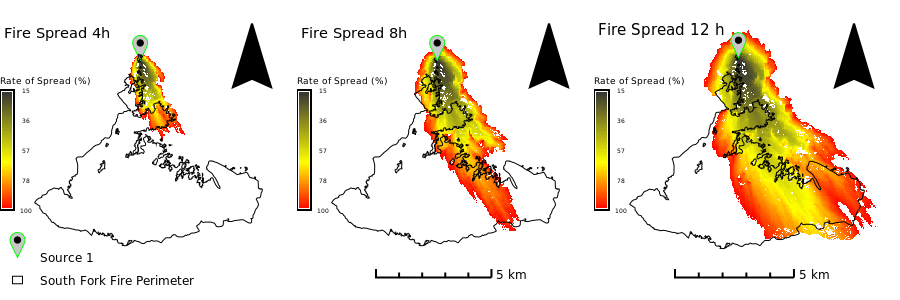

In [ ]:
Image(filename="gisdata/yosemite/images/sa_1_frame.png")

According to the output above, our fire spread is heading towards the 'South Fork' fire perimeter. We also observe that when the rate of spread reaches 12 hours, the simulated fire takes up a half of the past fire polygon with a width of approximately 4 km.

## 3.3 Study Area 2

Study area 2 is located in the center-west  of the Yosemite National Park  (<a href='#Figure 5'>Figure 5</a>). Mean slope is 10.87 degree, mean wind speed is 408.02 foot/min, mean dead fuel moisture 1 hour is 2.88%, and area is: 53.90 $km^2$. Predominant fuel classes are Timber (litter and understory) with a coverage of 31.28%, Closed timber litter with a cover of 29.91% , and Hardwood litter covering 15.08% of the study area (to learn more about fuel classes click [here](https://iftdss.firenet.gov/firenetHelp/help/pageHelp/content/10-mapstudio/files/fbfmsummaries.htm)). According to the NLCD: USGS National Land Cover Database (Yang et.al.,2018), this area is mainly covered by evergreen forest (69%), shrub/scrub (17%), and grassland/herbaceous(12%) (Figure 8).
<br>
<br>
<center><strong>Figure 8. Vegetation in Study Area 2</strong></center>
<img src="gisdata/yosemite/images/sa_2.jpg" width="400" align="center">
<center>Source: Google Maps Photos</center>

The goal of the fire simulation in this Region is to determine how wildfire simulation behaves in a small area on a ridgetop.

We'll begin by setting our Region to Study Area 2.

In [ ]:
# set region
g.region(region='sa_2R');

### 3.3.1 Calculating Data

We will apply the `calcdata()` function to our Study Area 2 to calculate:

- moisture_1h: raster map containing the 1-hour fuel moisture (%).
- moisture_live: raster map containing live fuel moisture (%).
- velocity: raster map containing wind velocities (ft/min).
- direction: raster map containing wind directions (degree).
- slope: raster map containing slope (degree).
- aspect: raster map containing aspect in degrees.

In [ ]:
caldata('sa_2R', '_sa_2')

'successfully calculated'

### 3.3.2  Modeling

Let's run the `r.ros` module for our Study Area 2. Note that we overwrite the `r.ros` outputs previously obtained.  

In [ ]:
# generates rate of spread raster map
r.ros(model='fuel', moisture_1h='moisture_1h_sa_2', \
    moisture_live='lfm_sa_2_scaled', velocity='wind_speed_sa_2', \
    direction='wind_dir_sa_2', slope='slope_sa_2', aspect='aspect_sa_2', \
    elevation='dem', base_ros='out_base_ros', \
    max_ros='out_max_ros', direction_ros='out_dir_ros', \
    spotting_distance='out_spotting');

Now, let's create a vector map from ASCII points  with the following coordinates: `26372.565416455524,-16680.564144390446
`.

Once the vector map has been created, we'll rasterize it. This raster map will be the source of our fire simulation.

In [ ]:
# create a vector map from an ASCII points
script.run_command('v.in.ascii',input='gisdata/yosemite/csv/source_2.txt', \
                   output='source_2', separator='comma')

# rasterize vector map
script.run_command('v.to.rast', input='source_2', output='source_2', type='point', use='cat');

We will run the  `r.spread` module up to 9 hours because for simulations beyond this time the execution fails. This failure could be due that in our Study Area, vegetation is surrounded by bare soil  (<a href='#Figure 9'>Figure 9</a>).

Let's run the `r.spread` module. Our start is the above-rasterized point. Our simulation period is 180 min (3 hours) because the initial time for the current simulation is `0` (default value) and our lag is `180` min. Note that we use the `"s"` flag because we are considering spotting distance.

In [ ]:
# elliptically anisotropic spread simulation 3 hours source 2
r.spread(flags="s", base_ros='out_dir_ros', max_ros='out_max_ros', \
    direction_ros='out_dir_ros', start='source_2', \
    spotting_distance='out_spotting', wind_speed='wind_speed_sa_2', \
    fuel_moisture='moisture_1h_sa_2', output='spread_3h_s2', lag=180);

In [ ]:
# set null values
r.null(map='spread_3h_s2', setnull=0)
# create color table
r.colors(map='spread_3h_s2', rules='gisdata/yosemite/csv/fire_colors.txt');

Let's run again the `r.spread` module. Our simulation period is `360` min (6 hours) because the initial time for the current simulation is `180` min and our lag is `180` min. Note that we use the `"si"` flags because we are considering spotting distance and our start is the output of the previous execution.

In [ ]:
# elliptically anisotropic spread simulation 6 hours source 2
script.run_command('r.spread', flags='si', base_ros='out_dir_ros', max_ros='out_max_ros', \
                   direction_ros='out_dir_ros', start='spread_3h_s2', \
                   spotting_distance='out_spotting', wind_speed='wind_speed_sa_2', \
                   fuel_moisture='moisture_1h_sa_2', output='spread_6h_s2', lag=180, init_time=180);

In [ ]:
# set null values
r.null(map='spread_6h_s2', setnull=0)
# create color table
r.colors(map='spread_6h_s2', rules='gisdata/yosemite/csv/fire_colors.txt');

Let's run again the `r.spread` module. Our simulation period is `540` min (9 hours) because the initial time for the current simulation is `360` min  and our lag is `180` min. Note that we use the "si" flags because we are considering spotting distance and our start is the output of the previous execution.

In [ ]:
# elliptically anisotropic spread simulation 9 hours source 2
script.run_command('r.spread', flags='si', base_ros='out_dir_ros', max_ros='out_max_ros', \
                   direction_ros='out_dir_ros', start='spread_6h_s2', \
                   spotting_distance='out_spotting', wind_speed='wind_speed_sa_2', \
                   fuel_moisture='moisture_1h_sa_2', output='spread_9h_s2', lag=180, init_time=360);

In [ ]:
# set null values
r.null(map='spread_9h_s2', setnull=0)
# create color table
r.colors(map='spread_9h_s2', rules='gisdata/yosemite/csv/fire_colors.txt');

### 3.3.3 Visualization

Having executed the r.ros and r.spread modules we can now visualize our results. Before setting up our visualization parameters we will reclassify `spread_9h_s2` raster map to create a legend bar depicting the rate of spread in percentage.

In [ ]:
# reclassify spread_9h_s2 to create a legend bar to depicting the rate of spread in percentage
reclassRast('spread_9h_s2')

'successfully calculated'

We will change the resolution because our base image is a high-resolution multispectral image.

In [ ]:
# change region resolution
g.region(res=3);

Let's import a subset of a high-resolution multispectral image.

In [ ]:
# import HR image
script.run_command('r.import', input='gisdata/yosemite/raster/subset.tif',output='subset');

Now, we will perform an auto-balancing of colors for the high-resolution image. We'll also combine red, green, and blue raster maps into a single composite raster map to create a [Color Infrared (CIR)](https://www.mngeo.state.mn.us/chouse/airphoto/cir.html) composite.

In [ ]:
# enhance colors subset image
script.run_command('i.colors.enhance',red='subset.4',green='subset.3', \
  blue='subset.2', strength=95);

In [ ]:
# combine red, green, and blue raster maps into a single composite raster map to create a CIR composite
r.composite(red='subset.4', green='subset.3', blue='subset.2', output='subset_cir');

In this case, our visualization output will consist of three frames. Each frame will contain the rate of spread raster for each time lag, a vector indicating the source of the simulation, the CIR composite, and the corresponding title, legends, scale, and north arrow.

In [ ]:
# display monitor and save image file
d.mon(start='cairo', output='gisdata/yosemite/images/sa_2_frame.png', width=800, height=400)

# remove all frames
d.frame(flags='e')

# frame spread_3h_s2
# create left frame
d.frame(flags='c', frame='first', at=(0,100,0,33))
# add raster map subset_cir
d.rast(map='subset_cir')
# add raster map spread_3h_s2
d.rast(map='spread_3h_s2')
# add vector map source_2
d.vect(map='source_2', size=25, icon='basic/pin_dot', color='green',legend_label='Source 2')
# add title
d.text(text='Fire Spread 3h', bgcolor=('255:255:204'), color='black', size=6)
# add raster legend
script.run_command('d.legend', flags='sb', raster='spread_9h_s2_reclass', \
                   at=(30,70, 7, 10), title='Spread (%)', title_fontsize= 7, bgcolor=('255:255:204'), \
                   border_color='none')
# add vector legend
script.run_command('d.legend.vect', flags='b', at=(7,15), symbol_size=10, fontsize=12, \
                   border_color='none', bgcolor=('255:255:204'))
# add north arrow
script.run_command('d.northarrow', flags='t', style='9',at=(85,85), fill_color=('255:255:204'), \
                   color='none')
# add bar scale
script.run_command('d.barscale', bgcolor=('255:255:204'), at=(50,30), style='line', \
                  length=500, units='meters', width_scale=0.5)


# frame spread_6h_s2
# create center frame
d.frame(flags='c', frame='second', at=(0,100,33,66))
# add raster map subset_cir
d.rast(map='subset_cir')
# add raster map spread_3h_s2
d.rast(map='spread_6h_s2')
# add vector map source_2
d.vect(map='source_2', size=25, icon='basic/pin_dot', color='green')
# add title
d.text(text='Fire Spread 6h', bgcolor=('255:255:204'), color='black', size=6)
# add bar scale
script.run_command('d.barscale', bgcolor=('255:255:204'), at=(40,10), style='line', \
                  length=1, units='kilometers', width_scale=0.5)
# add north arrow
script.run_command('d.northarrow', flags='t', style='9',at=(85,85), fill_color=('255:255:204'), \
                   color='none')
# add raster legend
script.run_command('d.legend', flags='sb', raster='spread_9h_s2_reclass', \
                   at=(30,70, 7, 10), title='Spread (%)', title_fontsize= 7, bgcolor=('255:255:204'), \
                   border_color='none')

# frame spread_9h_s2
# create right frame
d.frame(flags='c', frame='third', at=(0,100,66,100))
# add raster map subset_cir
d.rast(map='subset_cir')
# add raster map spread_9h_s2
d.rast(map='spread_9h_s2')
# add vector map source_2
d.vect(map='source_2', size=25, icon='basic/pin_dot', color='green')
# add title
d.text(text='Fire Spread 9 h', bgcolor=('255:255:204'), color='black', size=6)
# add north arrow
script.run_command('d.northarrow', flags='t', style='9',at=(85,85), fill_color=('255:255:204'), \
                   color='none')
# add raster legend
script.run_command('d.legend', flags='sb', raster='spread_9h_s2_reclass', \
                   at=(30,70, 7, 10), title='Spread (%)', title_fontsize= 7, bgcolor=('255:255:204'), \
                   border_color='none')
# add bar scale
script.run_command('d.barscale', bgcolor=('255:255:204'), at=(30,5), style='line', \
                  length=2, units='kilometers', width_scale=0.5)

# release and stop currently selected monitor and exit
d.mon(flags='r');

<a id='Figure 9'></a>
<center><strong>Figure 9. Results of Fire Simulation Study Area 2</strong></center>

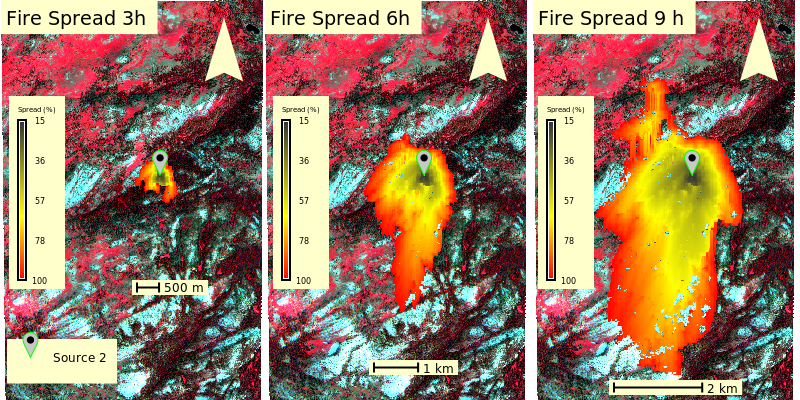

In [ ]:
Image(filename="gisdata/yosemite/images/sa_2_frame.png")

Let's open the output image in the image viewer to see more details.

In [ ]:
# open image in the Image Viewer
im = Img.open("gisdata/yosemite/images/sa_2_frame.png")
im.show()

According to the above output, our fire spread is constrained by the presence of bare soils among vegetation patches. We can also see how our simulation avoids bare soil (light blue patches within fire spread 9 h raster). It is important to highlight that our computations are based on 30m spatial resolution, so it is acceptable that our rate of spread raster maps overlaps some bare soils depicted in the high-resolution image. Total area of fire spread 13.03 $km^2$.

## 3.4 Study Area 3

Study area 3 is located in the center-east  of the Yosemite National Park  (<a href='#Figure 5'>Figure 5</a>). Mean slope is 14.49 degree, mean wind speed is  467.37 foot/min, mean dead fuel moisture 1 hour is 2.87% and area is: 270.26 $km^2$. Predominant fuel classes are Closed timber litter with a coverage of 29.70%, and Timber (grass and understory) covering 21.67% of the study area (to learn more about fuel classes click [here](https://iftdss.firenet.gov/firenetHelp/help/pageHelp/content/10-mapstudio/files/fbfmsummaries.htm)). According to the NLCD: USGS National Land Cover Database (Yang et.al.,2018), this area is mainly covered by evergreen forest (51%), shrub/scrub (34%), and grassland/herbaceous(5%) (Figure 8).
<br>
<br>
<center><strong>Figure 8. Vegetation in Study Area 3</strong></center>
<img src="gisdata/yosemite/images/sa_3.jpg" width="500" align="center">
<center>Source: Google Maps Photos</center>

The goal of the fire simulation in this Region is to determine how wildfire simulation behaves in a large area surrounded by mountains (valley), and during a long time (32 hours).

We'll begin by setting our Region to Study Area 3.

In [ ]:
# set region
g.region(region='sa_3R');

### 3.4.1 Calculating Data

We will apply the `calcdata()` function to our Study Area 3 to calculate:

- moisture_1h: raster map containing the 1-hour fuel moisture (%).
- moisture_live: raster map containing live fuel moisture (%).
- velocity: raster map containing wind velocities (ft/min).
- direction: raster map containing wind directions (degree).
- slope: raster map containing slope (degree).
- aspect: raster map containing aspect in degrees.

In [ ]:
caldata('sa_3R', '_sa_3')

'successfully calculated'

### 3.4.2  Modeling
Let's run the `r.ros` module for our Study Area 3. Note that we overwrite the `r.ros` outputs previously obtained.

In [ ]:
# generates rate of spread raster map
r.ros(model='fuel', moisture_1h='moisture_1h_sa_3', \
    moisture_live='lfm_sa_3_scaled', velocity='wind_speed_sa_3', \
    direction='wind_dir_sa_3', slope='slope_sa_3', aspect='aspect_sa_3', \
    elevation='dem', base_ros='out_base_ros', \
    max_ros='out_max_ros', direction_ros='out_dir_ros', \
    spotting_distance='out_spotting');

Now, let's create a vector map from ASCII points  with the following coordinates: `56978.3098189104,-12406.60548812005
`.

Once the vector map has been created, we'll rasterize it. This raster map will be the source of our fire simulation.

In [ ]:
# create a vector map from an ASCII points
script.run_command('v.in.ascii',input='gisdata/yosemite/csv/source_3.txt', \
                   output='source_3', separator='comma');

# rasterize vector map
script.run_command('v.to.rast', input='source_3', output='source_3', type='point', use='cat');

Let's run the `r.spread` module. Our start is the above-rasterized point. Our simulation period is 480 min (8 hours) because the initial time for the current simulation is `0` (default value) and our lag is `480` min. Note that we use the `"s"` flag because we are considering spotting distance.

In [ ]:
# elliptically anisotropic spread simulation 8 hours source 3
r.spread(flags="s", base_ros='out_dir_ros', max_ros='out_max_ros', \
    direction_ros='out_dir_ros', start='source_3', \
    spotting_distance='out_spotting', wind_speed='wind_speed_sa_3', \
    fuel_moisture='moisture_1h_sa_3', output='spread_8h_s3', lag=480);

In [ ]:
# set null values
r.null(map='spread_8h_s3', setnull=0);
# create color table
r.colors(map='spread_8h_s3', rules='gisdata/yosemite/csv/fire_colors.txt');

Let's run again the `r.spread` module. Our simulation period is `960` min (16 hours) because the initial time for the current simulation is `480` min and our lag is `480` min. Note that we use the `"si"` flags because we are considering spotting distance and our start is the output of the previous execution.

In [ ]:
# elliptically anisotropic spread simulation 16 hours source 3
script.run_command('r.spread', flags='si', base_ros='out_dir_ros', max_ros='out_max_ros', \
                   direction_ros='out_dir_ros', start='spread_8h_s3', \
                   spotting_distance='out_spotting', wind_speed='wind_speed_sa_3', \
                   fuel_moisture='moisture_1h_sa_3', output='spread_16h_s3', lag=480, init_time=480);

In [ ]:
# set null values
r.null(map='spread_16h_s3', setnull=0);
# create color table
r.colors(map='spread_16h_s3', rules='gisdata/yosemite/csv/fire_colors.txt');

Let's run again the `r.spread` module. Our simulation period is `1140` min (24 hours) because the initial time for the current simulation is `960` min  and our lag is `480` min. Note that we use the "si" flags because we are considering spotting distance and our start is the output of the previous execution.

In [ ]:
# elliptically anisotropic spread simulation 24 hours source 3
script.run_command('r.spread', flags='si', base_ros='out_dir_ros', max_ros='out_max_ros', \
                   direction_ros='out_dir_ros', start='spread_16h_s3', \
                   spotting_distance='out_spotting', wind_speed='wind_speed_sa_3', \
                   fuel_moisture='moisture_1h_sa_3', output='spread_24h_s3', lag=480, init_time=960);

In [ ]:
# set null values
r.null(map='spread_24h_s3', setnull=0);
# create color table
r.colors(map='spread_24h_s3', rules='gisdata/yosemite/csv/fire_colors.txt');

Let's run again the `r.spread` module. Our simulation period is `1932` min (32 hours) because the initial time for the current simulation is `1140` min  and our lag is `480` min. Note that we use the "si" flags because we are considering spotting distance and our start is the output of the previous execution.

In [ ]:
# elliptically anisotropic spread simulation 32 hours source 3
script.run_command('r.spread', flags='si', base_ros='out_dir_ros', max_ros='out_max_ros', \
                   direction_ros='out_dir_ros', start='spread_24h_s3', \
                   spotting_distance='out_spotting', wind_speed='wind_speed_sa_3', \
                   fuel_moisture='moisture_1h_sa_3', output='spread_32h_s3', lag=480, init_time=1440);

In [ ]:
# set null values
r.null(map='spread_32h_s3', setnull=0);
# create color table
r.colors(map='spread_32h_s3', rules='gisdata/yosemite/csv/fire_colors.txt');

### 3.4.3 Visualization

Having executed the r.ros and r.spread modules we can now visualize our results. Before setting up our visualization parameters we will reclassify `spread_32h_s3` raster map to create a legend bar depicting the rate of spread in percentage.

In [ ]:
# reclassify spread_24h_s3 to create a lengend bar depicting the rate of spread in percentage
reclassRast('spread_32h_s3')

'successfully calculated'

Now, we will perform an auto-balancing of colors for the Landsat 8 image. We'll also combine red, green, and blue raster maps into a single composite raster map to create a [Color Infrared (CIR)](https://www.mngeo.state.mn.us/chouse/airphoto/cir.html) composite.

In [ ]:
# enhance colors Landsat image
script.run_command('i.colors.enhance',red='landsat.5',green='landsat.4', \
  blue='landsat.3', strength=95);

In [ ]:
#  combine red, green and blue raster maps into a single composite raster map
# to create a  standard "false color" composite (5, 4 3)
r.composite(red='landsat.5', green='landsat.4', blue='landsat.3', output='landsat_cir_sa_3');

In this case, our visualization output will consist of four frames. Each frame will contain the rate of spread raster for each time lag, a vector indicating the source of the simulation, the CIR composite, and the corresponding title, legends, scale, and north arrow.

In [ ]:
# display monitor and save image file
d.mon(start='cairo', output='gisdata/yosemite/images/sa_3_frame.png', width=800, height=700)

# remove all frames
d.frame(flags='e')

# frame spread_8h_s3
# create upper-left frame
d.frame(flags='c', frame='first', at=(50,100,0,50))
# add raster map landsat cir
d.rast(map='landsat_cir_sa_3')
# add raster map spread_8h_s3
d.rast(map='spread_8h_s3')
# add vector map source_3
d.vect(map='source_3', size=25, icon='basic/pin_dot', color='green',legend_label='Source 3')
# add title
d.text(text='Fire Spread 8h', bgcolor=('255:255:204'), color='black', size=6)
# add north arrow
script.run_command('d.northarrow', flags='t', style='9',at=(85,85), fill_color=('0:0:0'), \
                   color='none')
# add raster legend
script.run_command('d.legend', flags='sb', raster='spread_32h_s3_reclass', \
                   at=(5,60, 81, 83), title='Spread (%)', title_fontsize= 7, bgcolor=('255:255:204'), \
                   border_color='none')
# add vector legend
script.run_command('d.legend.vect', flags='b', at=(7,15), symbol_size=10, fontsize=12, \
                   border_color='none', bgcolor=('255:255:204'))
# add bar scale
script.run_command('d.barscale', bgcolor=('255:255:204'), at=(40,10), style='line', \
                  length=2, units='kilometers', width_scale=0.5)


# frame spread_16h_s2
# create upper-right frame
d.frame(flags='c', frame='second', at=(50,100,50,100))
# add raster map landsat cir
d.rast(map='landsat_cir_sa_3')
# add raster map spread_16h_s3
d.rast(map='spread_16h_s3')
# add vector map source_3
d.vect(map='source_3', size=25, icon='basic/pin_dot', color='green')
# add title
d.text(text='Fire Spread 16h', bgcolor=('255:255:204'), color='black', size=6)
# add north arrow
script.run_command('d.northarrow', flags='t', style='9',at=(85,85), fill_color=('0:0:0'), \
                   color='none')
# add raster legend
script.run_command('d.legend', flags='sb', raster='spread_32h_s3_reclass', \
                   at=(5,60, 81, 83), title='Spread (%)', title_fontsize= 7, bgcolor=('255:255:204'), \
                   border_color='none')
# add bar scale
script.run_command('d.barscale', bgcolor=('255:255:204'), at=(40,10), style='line', \
                  length=4, units='kilometers', width_scale=0.5)



# frame spread_24h_s3
# create lower-left frame
d.frame(flags='c', frame='third', at=(0,50,0,50))
# add raster map landsat cir
d.rast(map='landsat_cir_sa_3')
# add raster map spread_24h_s3
d.rast(map='spread_24h_s3')
# add vector map source_3
d.vect(map='source_3', size=25, icon='basic/pin_dot', color='green')
# add title
d.text(text='Fire Spread 24h', bgcolor=('255:255:204'), color='black', size=6)
# add north arrow
script.run_command('d.northarrow', flags='t', style='9',at=(85,85), fill_color=('0:0:0'), \
                   color='none')
# add raster legend
script.run_command('d.legend', flags='sb', raster='spread_32h_s3_reclass', \
                   at=(5,60, 81, 83), title='Spread (%)', title_fontsize= 7, bgcolor=('255:255:204'), \
                   border_color='none')
# add bar scale
script.run_command('d.barscale', bgcolor=('255:255:204'), at=(30,10), style='line', \
                  length=6, units='kilometers', width_scale=0.5)


# frame spread_32h_s3
# create lower-right frame
d.frame(flags='c', frame='fourth', at=(0,50,50,100))
# add raster map landsat cir
d.rast(map='landsat_cir_sa_3')
# add raster map spread_32h_s3
d.rast(map='spread_32h_s3')
# add vector map source_3
d.vect(map='source_3', size=25, icon='basic/pin_dot', color='green')
# add title
d.text(text='Fire Spread 32h', bgcolor=('255:255:204'), color='black', size=6)
# add north arrow
script.run_command('d.northarrow', flags='t', style='9',at=(85,85), fill_color=('0:0:0'), \
                   color='none')
# add raster legend
script.run_command('d.legend', flags='sb', raster='spread_32h_s3_reclass', \
                   at=(5,60, 11, 14), title='Spread (%)', title_fontsize= 7, bgcolor=('255:255:204'), \
                   border_color='none')
# add bar scale
script.run_command('d.barscale', bgcolor=('255:255:204'), at=(30,8), style='line', \
                  length=9, units='kilometers', width_scale=0.5)

# release and stop currently selected monitor and exit
d.mon(flags='r');

<center><strong>Figure 10. Results of Fire Simulation Study Area 3</strong></center>

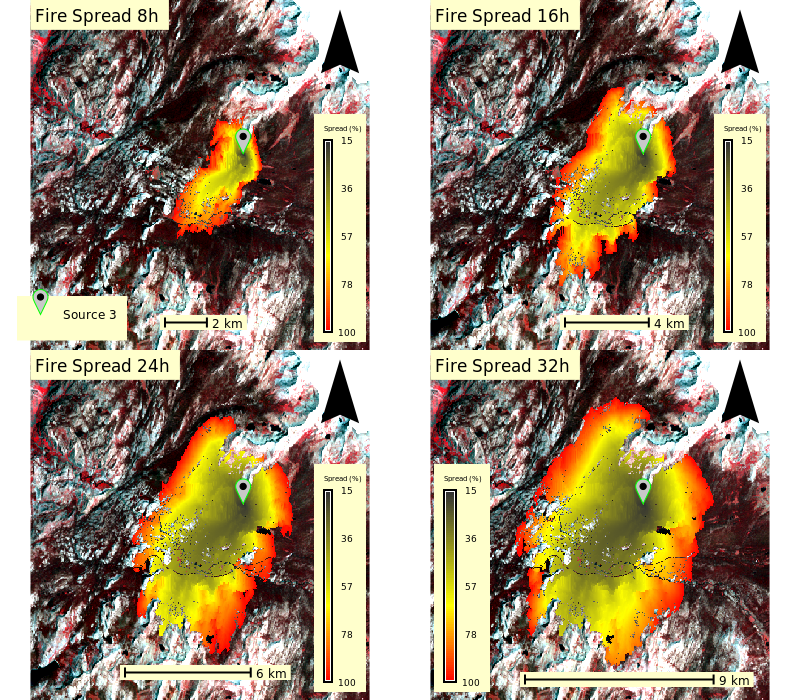

In [ ]:
Image(filename="gisdata/yosemite/images/sa_3_frame.png")

Let's open the output image in the image viewer to see more details.

In [ ]:
# open image on the Image Viewer
im = Img.open("gisdata/yosemite/images/sa_3_frame.png")
im.show()

We will create an animated gif image of our visualizations by using the GRASS GIS imaging package. First of all, we will create a separate image for each time lag using a for-loop iteration.

In [ ]:
# create list of lags
lags = ['0h','8h', '16h', '24h', '32h']
# iterate over lags
for i in lags:
    # set output path
    output ='gisdata/yosemite/images/sa_3_'+i+'.png'
    # display monitor and save image file
    d.mon(start='cairo', output=output, width=800, height=750)
    # remove all frames
    d.frame(flags='e')
    # create a frame
    d.frame(flags='c', frame='first', at=(0,100,0,100))
    # if lag is 0 hour
    if i == '0h':
        # add raster landsat cir
        d.rast(map='landsat_cir_sa_3')
        # add source 3 vector map
        d.vect(map='source_3', size=25, icon='basic/pin_dot', color='green')
        # add title
        text ='Fire Spread '+i
        d.text(text=text, bgcolor=('255:255:204'), color='black', size=4)
    else:
        # add raster landsat cir
        d.rast(map='landsat_cir_sa_3')
        # add raster fire spread
        map='spread_'+i+'_s3'
        d.rast(map=map)
        # add source 3 vectr map
        d.vect(map='source_3', size=25, icon='basic/pin_dot', color='green')
        # add title
        text ='Fire Spread '+i
        d.text(text=text, bgcolor=('255:255:204'), color='black', size=4)
    # release and stop currently selected monitor and exit
    d.mon(flags='r');

In [ ]:
# open resulting images with PIL
im0 = Img.open("gisdata/yosemite/images/sa_3_0h.png")
im1 = Img.open("gisdata/yosemite/images/sa_3_8h.png")
im2 = Img.open("gisdata/yosemite/images/sa_3_16h.png")
im3 = Img.open("gisdata/yosemite/images/sa_3_24h.png")
im4 = Img.open("gisdata/yosemite/images/sa_3_32h.png")
# create a list of images
images = [im0, im1,im2,im3, im4]

In [ ]:
# create the animated gif with GRASS Python imaging package
imaging.images2gif.writeGifPillow('gisdata/yosemite/images/Animation_Sa_3_2.gif', \
                                  images, duration=2, repeat=True)

<img src="gisdata/yosemite/images/Animation_Sa_3_2.gif" width="400" align="center">

According to the above output, our simulated fire spreads out towards the Yosemite valley generating a mega-fire. We can also see how our simulation avoids non-vegetated areas and goes over roads possibly due to the spotting effect. Total area of fire spread 72.54 $km^2$.

In [ ]:
# end the GRASS session
os.remove(rcfile)

# 4. Discussion

This tutorial demonstrates we can integrate GRASS GIS, Google Earth Engine, and Jupyter Notebook in a unique development environment. However, more work should be done in order to pass GEE and Geopandas objects into GRASS GIS modules.

The result of the Fire simulation in Study Area 1 could be used as an indicator of the modeling accuracy. We can simulate wildfires in areas affected by past fire events to compare simulated and real fires.

The results of the Fire simulation in Study Areas 2 and 3 suggest that the modeling raster outputs do not overlap non-vegetated areas. In our case, fire simulations perform better in large areas because our base spatial resolution is 30m which is suitable for studies at a regional scale. Data should be generated to simulate wildfire at a finer scale.

In this tutorial, for the `v.surf.idw` module we used default parameters. It could be interesting to try out different interpolation parameters and evaluate how they affect simulation outputs.

Finally, we suggest assessing fire spread outputs after running the `r.ros` and `r.sread` modules with field measurements of dead fuel moisture, live fuel moisture, wind velocity, and wind direction.

# 5. References

GRASS Development Team(2021). GRASS GIS 7.8.6dev Reference Manual. Retrieved April 17, 2021, from https://grass.osgeo.org/grass78/manuals/.

Petrasova, A., Harmon, B., Petras, V., Tabrizian, P., & Mitasova, H. (2018). Wildfire spread simulation. In Tangible Modeling with Open Source GIS (pp. 155-163). Springer, Cham.

Myoung, B., Kim, S. H., Nghiem, S. V., Jia, S., Whitney, K., & Kafatos, M. C. (2018). Estimating live fuel moisture from MODIS satellite data for wildfire danger assessment in Southern California USA. Remote Sensing, 10(1), 87.

Northern Rockies Coordination Center(n.d). PSA NFDRS Component Glossary. Retrieved April 16, 2021, from  
https://gacc.nifc.gov/nrcc/predictive/fuels_fire-danger/psa_component_glossary.htm

Planet Team (2017). Planet Application Program Interface: In Space for Life on Earth. San Francisco, CA. https://api.planet.com.

Yang, L., Jin, S., Danielson, P., Homer, C., Gass, L., Case, A., Costello, C., Dewitz, J., Fry, J., Funk, M., Grannemann, B., Rigge, M. and G. Xian. 2018, A New Generation of the United States National Land Cover Database: Requirements, Research Priorities, Design, and Implementation Strategies, p. 108–123.

Wikipedia. 2021. "Wildfire modeling." Last modified January 10, 2021.https://en.wikipedia.org/wiki/Wildfire_modeling.